# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [14]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from time import time

import torch
from torch import nn
# from torch import optim
# import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [17]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [8]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [9]:
# Use GPU if it's available
if torch.cuda.is_available():
    print('Running on GPU')
    device = torch.device('cuda:0')
else:
    print('Running on CPU')
    device = torch.device('cpu')

# Freeze parameters so we don't train/backpropagate through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003,
                             weight_decay=0)

model.to(device);

Running on GPU


In [8]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5

training_losses = []
testing_losses = []

start = time()

for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        
        # move input and label tensors to the appropriate device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # !Important: restart optimizer for every new step
        optimizer.zero_grad()
        
        # Perform forward pass to transform input into output
        outputs = model.forward(inputs) # since last layer is LogSoftMax, output is Log
            
        # Calculate error. Using Negative Log Loss instead of delta probability
        loss = criterion(outputs, labels)
        
        # Back propagate
        loss.backward()
        
        # Calibrate Weights based on Gradient Descent
        optimizer.step()
        
        # Keep track of training progress
        running_loss += loss.item()
        training_losses.append(running_loss)
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval() #! Important: enter evaluation mode, no drop-out applied
            
            with torch.no_grad(): # ! Important: no gradient descent on following calculations
                for inputs, labels in test_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = model.forward(inputs)
                    batch_loss = criterion(outputs, labels)
                    
                    test_loss += batch_loss.item()
                    testing_losses.append(test_loss)
                    
                    # Transform output into probability format
                    probabilities = torch.exp(outputs) #proba = exp^(log)
                    top_p, top_class = probabilities.topk(1, dim=1) # returns class with higher probability score
                    
                    # Calculate Accuracy
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f'Epoch {epoch+1}/{epochs} |'
                  f'Train Loss: {running_loss/print_every :.3f} |'
                  f'Test Loss: {test_loss/len(test_loader) :.3f} |'
                  f'Test Accuracy: {accuracy/len(test_loader) :.3%} |'
                  f'Time: {(time()-start):.0f} sec')
            
            # Reset to training mode (apply drop-out) and restart tally for next epoch
            running_loss = 0
            model.train()
print(f'Total training time: {(time() - start):.0f} sec')            

Epoch 1/1 |Train Loss: 0.126 |Test Loss: 0.056 |Test Accuracy: 97.891% |Time: 23 sec
Epoch 1/1 |Train Loss: 0.171 |Test Loss: 0.074 |Test Accuracy: 97.148% |Time: 47 sec
Epoch 1/1 |Train Loss: 0.205 |Test Loss: 0.057 |Test Accuracy: 97.969% |Time: 70 sec
Epoch 1/1 |Train Loss: 0.209 |Test Loss: 0.068 |Test Accuracy: 97.422% |Time: 94 sec
Epoch 1/1 |Train Loss: 0.232 |Test Loss: 0.056 |Test Accuracy: 98.008% |Time: 117 sec
Epoch 1/1 |Train Loss: 0.224 |Test Loss: 0.054 |Test Accuracy: 98.164% |Time: 140 sec
Epoch 1/1 |Train Loss: 0.150 |Test Loss: 0.054 |Test Accuracy: 98.164% |Time: 164 sec
Epoch 1/1 |Train Loss: 0.170 |Test Loss: 0.052 |Test Accuracy: 98.281% |Time: 187 sec
Epoch 1/1 |Train Loss: 0.118 |Test Loss: 0.070 |Test Accuracy: 97.461% |Time: 211 sec
Epoch 1/1 |Train Loss: 0.307 |Test Loss: 0.079 |Test Accuracy: 97.305% |Time: 234 sec
Epoch 1/1 |Train Loss: 0.253 |Test Loss: 0.072 |Test Accuracy: 97.422% |Time: 257 sec
Epoch 1/1 |Train Loss: 0.147 |Test Loss: 0.050 |Test Accur

### Plot Training vs Test Loss

Text(0.5,0,'step')

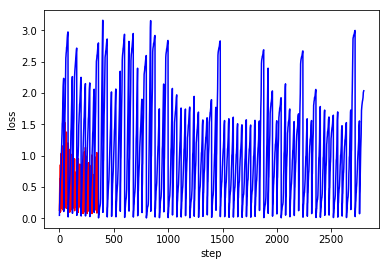

In [21]:
plt.plot(training_losses, label='train', color='r')
plt.plot(testing_losses, label='test', color='b')
plt.ylabel('loss')
plt.xlabel('step')

### Saving a checkpoint

In [27]:
# Once completed, save model as checkpoint
checkpoint = {'epoch':epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth') # currently, 30 mb

### Loading from Checkpoint

In [30]:
# First, define base model and optimizer
model2 = models.densenet121(pretrained=True)
optimizer2 = torch.optim.Adam(model.classifier.parameters())

# Apply same custom tranformation on last step (classifier)
for param in model2.parameters():
    param.requires_grad = False
    
model2.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

# Deserialize 'pickled' file
checkpoint = torch.load('checkpoint.pth')

# load model and optimizer saved state data
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

# Make sure model is ready to be used for classifying/evaluation
model2.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu